# Raveling: Detecting fraudulent transactions

### Detailed description goes here

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from statistics import mean
from statistics import stdev
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, make_scorer, log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import pickle

In [2]:
print(sys.executable)

/Users/viktoria/opt/anaconda3/envs/ravelin/bin/python


Define directories

In [3]:
base = '/Users/Viktoria/Desktop/Fraud_project'
code = os.path.join(base, 'code')
raw = os.path.join(base, 'raw_data')
preproc = os.path.join(base, 'preprocessed_data')
viz = os.path.join(base, 'visualisation')
res = os.path.join(base, 'results')

Import the dataset ('raw_data/customers.json')

In [4]:
os.chdir(raw)
customers = pd.DataFrame()
for line in open('customers.json', 'r'):
    customers = customers.append(pd.json_normalize(json.loads(line)))

customers = customers.reset_index(drop=True)

In [5]:
customers.shape

(168, 9)

In [6]:
customers.head()

,fraudulent,orders,paymentMethods,transactions,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress
0,False,"[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb...",josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896"
1,True,"[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg...",evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...
2,False,"[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3...",andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250"
3,False,"[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz...",rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM..."
4,True,"[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h...",uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,..."


### 1. Exploring variables: determine the units of observation

In [7]:
len(customers['customer.customerEmail'].unique())

161

In [8]:
[(c, type(customers.loc[0,c])) for c in customers.columns]

[('fraudulent', numpy.bool_),
 ('orders', list),
 ('paymentMethods', list),
 ('transactions', list),
 ('customer.customerEmail', str),
 ('customer.customerPhone', str),
 ('customer.customerDevice', str),
 ('customer.customerIPAddress', str),
 ('customer.customerBillingAddress', str)]

In [9]:
print('Fraud: ', len(customers[customers['fraudulent']==True]), '\nNon-fraud: ', len(customers[customers['fraudulent']==False]))

Fraud:  61 
Non-fraud:  107


Find out how the variables relate to one another. Dictionary keys must be linked.

In [10]:
print(customers.loc[0, 'orders'][0].keys())

dict_keys(['orderId', 'orderAmount', 'orderState', 'orderShippingAddress'])


In [11]:
print(customers.loc[0, 'transactions'][0].keys())

dict_keys(['transactionId', 'orderId', 'paymentMethodId', 'transactionAmount', 'transactionFailed'])


In [12]:
print(customers.loc[0, 'paymentMethods'][0].keys())

dict_keys(['paymentMethodId', 'paymentMethodRegistrationFailure', 'paymentMethodType', 'paymentMethodProvider', 'paymentMethodIssuer'])


Each order is related to a transaction through 'orderId'. Each payment method is related to a transaction through paymentMethodId.

The units of observation shall be transactions. Create a dataframe where each transaction is a row.

In [13]:
transactions = pd.DataFrame()

for row,val in tqdm(customers.iterrows()):
    
    transaction_list = customers.loc[row, 'transactions']
    order_list = customers.loc[row, 'orders']
    payment_list = customers.loc[row, 'paymentMethods']
    
    #each transaction will be a row - find the corresponding info
    for t in transaction_list:
        
        cust_info = pd.DataFrame(val).T.reset_index(drop=True)
        trans_info = pd.DataFrame.from_dict({k:v for k,v in t.items()}, orient='index').T
       
    
        #identify the corresponding order
        try:
            this_order = [o for o in order_list if o.get('orderId')==t.get('orderId')][0]
            order_info = pd.DataFrame.from_dict({k:v for k,v in this_order.items()}, orient='index').T
        except:
            order_info = pd.DataFrame(data={'orderId':[None], 
                                            'orderAmount':[None], 
                                            'orderState':[None], 
                                            'orderShippingAddress':[None]})
    
        
        #identify the corresponding payment info
        try:
            this_payment = [p for p in payment_list if p.get('paymentMethodId')==t.get('paymentMethodId')][0]
            payment_info = pd.DataFrame.from_dict({k:v for k,v in this_payment.items()}, orient='index').T
        except:
            payment_info = pd.DataFrame(data={'paymentMethodId':[None], 
                                              'paymentMethodRegistrationFailure':[None], 
                                              'paymentMethodType':[None], 
                                              'paymentMethodProvider':[None], 
                                              'paymentMethodIssuer':None})
        
            
        #join them
        newrow = pd.concat([cust_info, trans_info, order_info, payment_info], axis=1)
        newrow = newrow.loc[:, ~newrow.columns.duplicated()]
        transactions = transactions.append(newrow).reset_index(drop=True)
        
        
transactions = transactions.drop(['orders', 'paymentMethods', 'transactions', 'orderAmount'], axis=1)

168it [00:01, 157.36it/s]


In [14]:
transactions.head()

,fraudulent,customer.customerEmail,customer.customerPhone,customer.customerDevice,customer.customerIPAddress,customer.customerBillingAddress,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer
0,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",a9lcj51r,vjbdvd,wt07xm68b,18,False,pending,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks
1,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",y4wcv03i,yp6x27,wt07xm68b,26,False,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks
2,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,5mi94sfw,nlghpa,41ug157xz,45,False,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",False,bitcoin,American Express,Bastion Banks
3,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,br8ba1nu,uw0eeb,41ug157xz,23,False,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,False,bitcoin,American Express,Bastion Banks
4,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,a33145ss,bn44oh,y3xp697jx,43,True,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",True,bitcoin,VISA 16 digit,Solace Banks


In [15]:
os.chdir(preproc)
transactions.to_csv('transactions.csv')

In [16]:
transactions.shape

(623, 17)

In [17]:
transactions.columns

Index(['fraudulent', 'customer.customerEmail', 'customer.customerPhone',
       'customer.customerDevice', 'customer.customerIPAddress',
       'customer.customerBillingAddress', 'transactionId', 'orderId',
       'paymentMethodId', 'transactionAmount', 'transactionFailed',
       'orderState', 'orderShippingAddress',
       'paymentMethodRegistrationFailure', 'paymentMethodType',
       'paymentMethodProvider', 'paymentMethodIssuer'],
      dtype='object')

In [18]:
len(transactions[transactions.fraudulent==True])

257

In [19]:
len(transactions[transactions.fraudulent==False])

366

## 2. Visual exploration

### 2.1. Payment methods: Are some payment methods associated with more fraudulent activity?

In [20]:
#Get the payment methods used in the two classes

methods = transactions.groupby('fraudulent')['paymentMethodType'].value_counts()
methods = methods.to_frame().rename(columns={'paymentMethodType':'Count'}).reset_index(drop=False)

#Convert to percentages
numfraud = len(transactions[transactions.fraudulent==True])
numnonfraud = len(transactions) - numfraud

methods['Percentage'] = methods.apply(lambda x: x['Count']/numfraud if x['fraudulent']==True else x['Count']/numnonfraud, axis=1)
methods.head()

,fraudulent,paymentMethodType,Count,Percentage
0,False,card,276,0.754098
1,False,paypal,40,0.109290
2,False,apple pay,27,0.073770
3,False,bitcoin,23,0.062842
4,True,card,203,0.789883


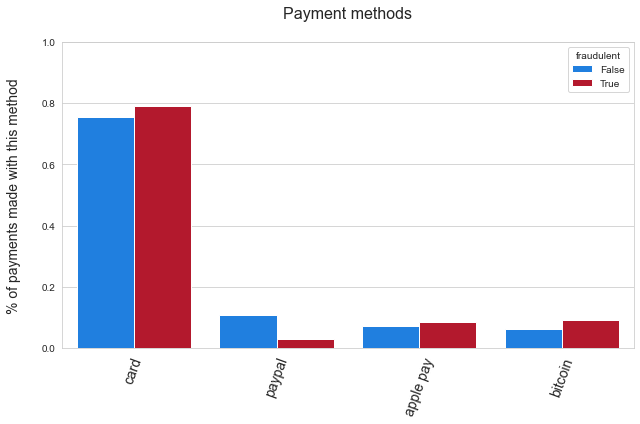

In [21]:
os.chdir(viz)

sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
bar = sns.barplot(x='paymentMethodType',  y='Percentage', data=methods, hue='fraudulent', palette=[(0, 0.5, 1), (0.8, 0, 0.1)])
plt.ylabel('% of payments made with this method\n', fontsize=14)
plt.ylim([0, 1])
plt.xlabel('')
plt.xticks(fontsize=14, rotation=70)
plt.title(('Payment methods\n'), fontsize = 16)
plt.tight_layout() 

plt.savefig('payment_methods.pdf')

Paypal seems to be safer than the other methods, whereas bitcoin carries slightly more risk.

### 2.2. Payment providers: Are some providers more at risk of fraudulent activity?

In [22]:
#Get the payment method provider used in the two classes
providers = transactions.groupby('fraudulent')['paymentMethodProvider'].value_counts()
providers = providers.to_frame().rename(columns={'paymentMethodProvider':'Count'}).reset_index(drop=False)

#Convert to percentages
numfraud = len(transactions[transactions.fraudulent==True])
numnonfraud = len(transactions) - numfraud

providers['Percentage'] = providers.apply(lambda x: x['Count']/numfraud if x['fraudulent']==True else x['Count']/numnonfraud, axis=1)
providers.head()

,fraudulent,paymentMethodProvider,Count,Percentage
0,False,JCB 16 digit,67,0.183060
1,False,Maestro,53,0.144809
2,False,VISA 16 digit,51,0.139344
3,False,Diners Club / Carte Blanche,38,0.103825
4,False,JCB 15 digit,31,0.084699


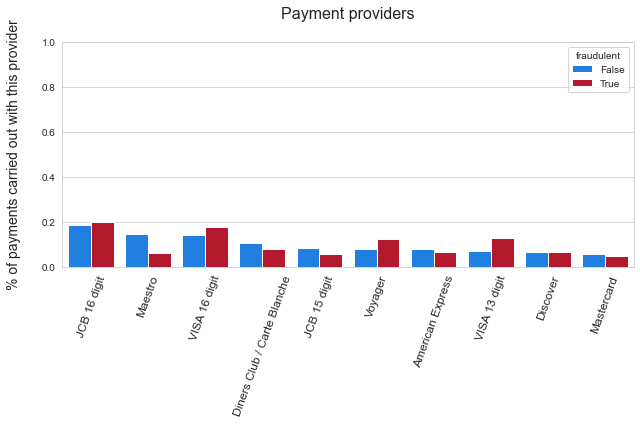

In [23]:
os.chdir(viz)

plt.figure(figsize=(9,6))
bar = sns.barplot(x='paymentMethodProvider',  y='Percentage', data=providers, hue='fraudulent', palette=[(0, 0.5, 1), (0.8, 0, 0.1)])
plt.ylabel('% of payments carried out with this provider\n', fontsize=14)
plt.ylim([0, 1])
plt.xlabel('')
plt.xticks(fontsize=12, rotation=70)
plt.title(('Payment providers\n'), fontsize = 16)
plt.tight_layout() 

plt.savefig('payment_providers.pdf')

Payment provider might be a good predictor: less fraudulent activity with Maestrocard, more with Voyager.

### 2.3. Are more expensive orders more likely to be fraudulent?

In [24]:
print(transactions.groupby('fraudulent')['transactionAmount'].mean())

fraudulent
False    29.049180
True     42.501946
Name: transactionAmount, dtype: float64


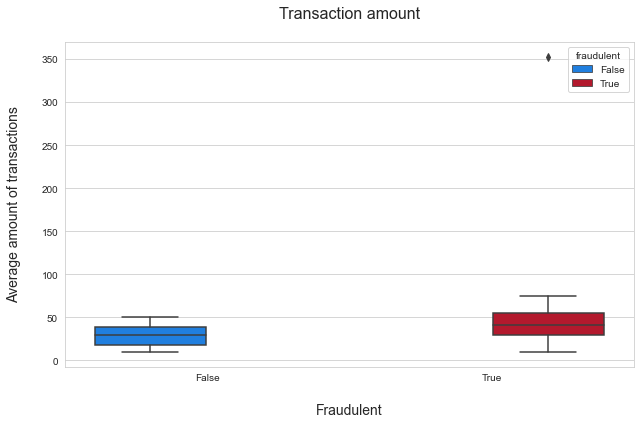

In [25]:
os.chdir(viz)

plt.figure(figsize=(9,6))

box = sns.boxplot(x='fraudulent', y='transactionAmount', data=transactions, hue='fraudulent', palette=[(0, 0.5, 1), (0.8, 0, 0.1)])
plt.ylabel('Average amount of transactions\n', fontsize=14)
plt.xlabel('\nFraudulent', fontsize=14)
plt.title(('Transaction amount\n'), fontsize = 16)
plt.tight_layout() 

plt.savefig('transaction_amounts.pdf')

Yes, fraudulent activity is associated with slightly higher transaction amounts, but this is probably not statistically significant (judging from the error bars)

## 3. Feature engineering

### 3.1. Eliminate nominal variables with lots of unique values (e.g. an id number)

In [26]:
for c in transactions.columns:
    print(c, ' ', len(transactions[c].unique()), len(customers))

fraudulent   2 168
customer.customerEmail   136 168
customer.customerPhone   141 168
customer.customerDevice   141 168
customer.customerIPAddress   138 168
customer.customerBillingAddress   139 168
transactionId   623 168
orderId   478 168
paymentMethodId   237 168
transactionAmount   67 168
transactionFailed   2 168
orderState   3 168
orderShippingAddress   274 168
paymentMethodRegistrationFailure   2 168
paymentMethodType   4 168
paymentMethodProvider   10 168
paymentMethodIssuer   19 168


In [27]:
transactions = transactions.drop(['transactionId', 'orderId', 'paymentMethodId'], axis=1)

### 3.2. Check for incongruities : the same email registered with multiple phone numbers, etc

Flag transactions where personal data doesn't match or the shipping address is different from the billing address

In [28]:
match_personal = transactions.groupby('customer.customerEmail')[['customer.customerPhone', 
                                                                 'customer.customerBillingAddress', 
                                                                 'customer.customerIPAddress', 
                                                                 'customer.customerDevice']].apply(lambda x: x.nunique()).reset_index(drop=False)

incongruous =  match_personal[(match_personal['customer.customerPhone'] > 1) |
               (match_personal['customer.customerBillingAddress'] > 1) |
               (match_personal['customer.customerIPAddress'] > 1) |
               (match_personal['customer.customerDevice'] > 1)]

emails = incongruous['customer.customerEmail'].tolist()

conditions = [(transactions['customer.customerEmail'].isin(emails)),
              (transactions['customer.customerBillingAddress']!=transactions['orderShippingAddress']),
              ~(transactions['customer.customerEmail'].isin(emails))]
values= [True, True, False]

transactions['incongruity'] = np.select(conditions, values)

In [29]:
#transactions[transactions['customer.customerEmail'].isin(emails)]

There was 1 customer who was registered with 6 different phones/addresses, ect and carried out 28 fraudulent transactions.

In [30]:
transactions = transactions.drop(['customer.customerPhone', 'customer.customerEmail', 'customer.customerBillingAddress', 'customer.customerDevice', 'customer.customerIPAddress', 'orderShippingAddress'], axis=1)

### 3.3. Encode categorical cariables

In [31]:
Y = transactions['fraudulent'].astype('category').cat.codes
transactions = transactions.drop(['fraudulent'], axis=1)

In [32]:
for col in transactions.columns:
    
    if col == 'transactionAmount':
        pass
    elif isinstance(transactions.loc[0, col], bool):
        transactions[col] = transactions[col].astype('category').cat.codes
    else:
        cat_data = pd.get_dummies(transactions[col],prefix = col)
        transactions = pd.concat([transactions, cat_data], axis = 1)
        transactions = transactions.drop([col], axis=1)

In [33]:
transactions.head()

,transactionAmount,transactionFailed,paymentMethodRegistrationFailure,orderState_failed,orderState_fulfilled,orderState_pending,paymentMethodType_apple pay,paymentMethodType_bitcoin,paymentMethodType_card,paymentMethodType_paypal,...,paymentMethodIssuer_a,paymentMethodIssuer_c,paymentMethodIssuer_e,paymentMethodIssuer_n,paymentMethodIssuer_o,paymentMethodIssuer_p,paymentMethodIssuer_r,paymentMethodIssuer_x,incongruity_0,incongruity_1
0,18,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,26,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,45,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,23,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,43,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## 4. Modelling

Supervised machine learning to predict whether a transaction is fraudulent. Using random forests, as it performs well with imbalanced data in my 

In [34]:
#Grid search best parameters

X = transactions

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,  random_state = 101)

# Number of trees in random forest
n_estimators = sp_randint(1, 1000)

#Number of features to consider at every split
max_features = sp_randint(1, len(X.columns))

# Minimum number of samples required to split a node
min_samples_split = sp_randint(2,100)

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
search_params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'min_samples_split': min_samples_split,
                 'bootstrap': bootstrap}

grid_search=RandomizedSearchCV(RandomForestClassifier(class_weight='balanced'),
                               n_iter=100,
                               param_distributions=search_params,
                               cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1),
                               n_jobs=-1)

In [35]:
grid_search.fit(X_train,Y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9290e37f10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9290eaffa0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9290ed0520>})

In [36]:
print('The best Params to use are \n', grid_search.best_params_ )
print('Which gives the best cross validation score of', grid_search.best_score_ )

The best Params to use are 
 {'bootstrap': False, 'max_features': 2, 'min_samples_split': 7, 'n_estimators': 134}
Which gives the best cross validation score of 0.7954580225664564


In [37]:
best_params = grid_search.best_params_
random_forest = RandomForestClassifier(**best_params)

best_model = grid_search.best_estimator_
                        
Y_pred = (best_model.predict_proba(X_test)[:,1] >= 0.4).astype(bool)
#Y_pred = best_model.predict(X_test)

In [38]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       121
           1       0.75      0.93      0.83        85

    accuracy                           0.84       206
   macro avg       0.84      0.85      0.84       206
weighted avg       0.86      0.84      0.84       206



In [39]:
print(accuracy_score(Y_test, Y_pred))

0.8398058252427184


Get feature importances

In [40]:
def r2(best_model, X_train, Y_train):
    return r2_score(Y_train, best_model.predict(X_train))

perm_imp_rfpimp = permutation_importances(best_model, X_train, Y_train, r2)

In [41]:
os.chdir(res)
perm_imp_rfpimp.to_csv('feature_importances.csv')

Check for overfitting

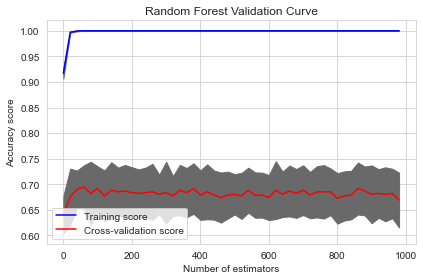

In [44]:
#Check for the number of estimators (or number of features)
estimator_range = np.arange(1, 1000, 20)
feature_range = np.arange(1, 100, 5)
train_scores, test_scores = validation_curve(
                            RandomForestClassifier(),
                            X,
                            Y,
                            param_name = 'n_estimators',
                            param_range = estimator_range,
                            scoring = 'accuracy',
                            n_jobs = -1)

#Calculate means and SDs for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

#Now for the test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#Plot mean accuracy for training and test sets
plt.plot(estimator_range, train_mean, label='Training score', color='blue')
plt.plot(estimator_range, test_mean, label='Cross-validation score', color='red')

#Plot accuracy bands for training and test sets
plt.fill_between(estimator_range, train_mean - train_std, train_mean + train_std, color='dimgray')
plt.fill_between(estimator_range, test_mean - test_std, test_mean + test_std, color = 'dimgray')

plt.title('Random Forest Validation Curve')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy score')
plt.tight_layout()
plt.legend(loc=3)
plt.show()                  

Save the model for future use

In [45]:
os.chdir(res)

pickle.dump(best_model, open('RF_model.sav', 'wb'))